# Just to hide things

In [126]:
!pip install missingno

In [3]:
import pandas as pd

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# Further cleaning

In [ ]:
result['start_date'] = pd.to_datetime(result['start_date'], errors='coerce')

In [ ]:
result['end_date'] = pd.to_datetime(result['end_date'], errors='coerce')

In [ ]:
allowed_values = ['Amber', 'Green', 'Red', 'Amber/red', 'Amber/Green']
result['colour_rating_new'] = result['colour_rating_new'].apply(lambda x: x if x in allowed_values else np.nan)

In [ ]:
result = result.rename(columns={'colour_rating_new': 'colour_rating'})

In [ ]:
result['yearly_forecast_new'] = result['yearly_forecast'].combine_first(result['forecast_incl_NGC'])

In [ ]:
result = result.drop(columns=['yearly_forecast', 'forecast_incl_NGC'])

In [ ]:
result = result.rename(columns={'yearly_forecast_new': 'yearly_forecast'})

In [ ]:
result = result.drop(columns=['yearly_budget'])

In [ ]:
result = result.rename(columns={'total_baseline': 'yearly_budget'})
result = result.rename(columns={'TOTAL Baseline Benefits (Łm)': 'total_benefits'})

In [ ]:
column_order = ['project_name','department','colour_rating','description_aims','rating_comment','start_date','end_date','schedule_comment','yearly_budget','yearly_forecast','wlc_baseline_incl_NCG','variance_comment','budget_comment','year','report_category','project_number','total_benefits','benefits_comment']

In [ ]:
result = result[column_order]

In [ ]:
df_macro = pd.read_csv('../data/macro/GDP.csv',encoding='iso-8859-2', delimiter=';')

In [ ]:
df_macro

In [ ]:
df_macro.info()

In [ ]:
df_franzi = pd.read_csv('../data/EDA/2021_2023.csv')

In [ ]:
# Schritt 1: Identifizieren der relevanten Zeilen
remained_scheduled_df = df_franzi[df_franzi['schedule_comment'].str.contains('remained scheduled', case=False)]

# Schritt 2: Aktuellsten 'end_date'-Wert für jedes 'project_name' ermitteln
latest_end_dates = df_franzi.groupby('project_name').apply(lambda x: x.loc[x['year'].idxmax(), 'end_date'])

# Schritt 3: Zuweisen des aktuellsten 'end_date' an die relevanten Zeilen
for index, row in remained_scheduled_df.iterrows():
    latest_end_date = latest_end_dates[row['project_name']]
    if pd.isna(row['end_date']) and pd.notna(latest_end_date):
        df_franzi.at[index, 'end_date'] = latest_end_date

# Ergebnis anzeigen
df_franzi


In [ ]:
# Schritt 2: Aktuellsten 'end_date'-Wert für jedes 'project_name' ermitteln
latest_end_dates = df_franzi.groupby('project_name').apply(lambda x: x.loc[x['year'].idxmax(), 'start_date'])

# Schritt 3: Zuweisen des aktuellsten 'end_date' an die relevanten Zeilen
for index, row in remained_scheduled_df.iterrows():
    latest_end_date = latest_end_dates[row['project_name']]
    if pd.isna(row['start_date']) and pd.notna(latest_end_date):
        df_franzi.at[index, 'start_date'] = latest_end_date

# Ergebnis anzeigen
df_franzi

In [ ]:
    month_mapping = {
        'jan': '01', 'january': '01',
        'feb': '02', 'february': '02',
        'mar': '03', 'march': '03',
        'apr': '04', 'april': '04',
        'may': '05', 'may': '05',
        'jun': '06', 'june': '06',
        'jul': '07', 'july': '07',
        'aug': '08', 'august': '08',
        'sep': '09', 'september': '09',
        'oct': '10', 'october': '10',
        'nov': '11', 'november': '11',
        'dec': '12', 'december': '12'
    }



In [ ]:
def extract_date_after_to_or_on(comment):
    REGEX = "(to|is|on)\s*(\d{1,2})\s+(\w+)\s+(\d{2,4})"
    x = re.compile(REGEX)
    
    match_REGEX = x.search(comment)      
    
    if match_REGEX:
        day = match_REGEX.group(2)
        month = match_REGEX.group(3)
        year = match_REGEX.group(4)
        if len(day) == 1:
            day = '0'+ day
        month = month_mapping.get(month.lower())
        if len(year) == 2:
            year = '20' + year
        return year +'-'+ month +'-'+ day
    
for index, row in df_franzi.iterrows():
    if pd.isna(row['end_date']):
        extracted_date = extract_date_after_to_or_on(row['schedule_comment'])
        if extracted_date:
            df_franzi.at[index, 'end_date'] = extracted_date

df_franzi



In [ ]:
# Der Code zum Filtern von Zeilen, in denen 'start_date' oder 'end_date' 'NaN' ist
# und die 'schedule_comment' nicht mit 'Exempt' oder '\r\nExempt' beginnen

nan_dates_df = df_franzi[
    ((df_franzi['end_date'].isna())) & 
    (~df_franzi['schedule_comment'].str.match(r'^(Exempt|\r\nExempt)'))
][['start_date', 'end_date', 'schedule_comment']]

# Ausgabe des gefilterten DataFrames
nan_dates_df

In [ ]:
# Der Code zum Filtern von Zeilen, in denen 'start_date' oder 'end_date' 'NaN' ist
# und die 'schedule_comment' nicht mit 'Exempt' oder '\r\nExempt' beginnen

nan_dates_df_start = df_franzi[
    ((df_franzi['start_date'].isna())) & 
    (~df_franzi['schedule_comment'].str.match(r'^(Exempt|\r\nExempt)'))
][['start_date', 'schedule_comment']]

# Ausgabe des gefilterten DataFrames
nan_dates_df_start

In [171]:
df1 = pd.read_pickle("../data/pickle/cleaned_2021_2023.pkl")
df2 = pd.read_pickle('../data/pickle/cleaned_2018_2020.pkl')
df3 = pd.read_pickle('../data/pickle/cleaned_2014-2017.pkl')
df4 = pd.read_csv('../data/macro/GDP.csv',encoding='iso-8859-2', delimiter=';')

In [172]:
df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

In [173]:
df = df.merge(df4, on='year', how='left')

In [174]:
df.drop(columns='Unnamed: 0')

,project_name,department,colour_rating,description_aims,rating_comment,start_date,end_date,schedule_comment,yearly_budget,yearly_forecast,...,GDP,annual_earning_ft,unemployment_rate,youth_unemployment_rate,inflation_rate,population,gov_debt,tax_revenue,revenue_excl_grants,grants_and_other_revenue
0,Civil Service Pensions 2015 Remedy,CO,Amber,The 2015 Pensions Remedy Programme was created...,"Compared to financial year 21/22-Q4, the Deliv...",2020-05-20,2024-09-30,"Compared to financial year 21/22-Q4, the proje...",7.90,4.20,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
1,Commercial Capability Expansion Programme,CO,Amber,The original Commercial Capability Programme s...,"Compared to financial year 21/22-Q4, the Seni...",2017-04-01,2023-03-31,"Compared to financial year 21/22-Q4, the proje...",3.70,3.10,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
2,Falcon IT Platform Refresh and Migration,CO,Amber,Falcon is a business change programme that wil...,The Senior Responsible Owner's Delivery Confid...,2022-05-01,2025-03-31,The project's end-date at 22/23-Q4 is 2025-03-...,0.00,0.00,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
3,Future Service Programme,CO,Amber,Future Services Programme is a series of procu...,"Compared to financial year 21/22-Q4, the Deliv...",2020-10-01,2025-12-31,"Compared to financial year 21/22-Q4, the proje...",1.60,1.70,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
4,GOV.UK One Login,CO,Amber,GOV.UK One Login will provide a single account...,"Compared to financial year 21/22-Q4, the Infra...",2021-01-04,2025-03-31,"Compared to financial year 21/22-Q4, the proje...",114.00,114.00,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,IT Transformation Programme,NCA,Amber,IT Transformation is one of three programmes t...,The IPA Review Team made 7 recommendations whe...,2016-04-01 00:00:00,2022-07-31 00:00:00,Schedule on track,14.00,14.00,...,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0
1726,NCA Transformation Programme,NCA,Amber,The NCAÂs Transformation Programme which will...,The current status of the NCA Transformation P...,2014-04-01 00:00:00,2019-03-31 00:00:00,Schedule on track,25.50,25.50,...,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0
1727,Census Transformation Programme,ONS,Amber,The Census Transformation Programme will run f...,1. ONS requires greater clarity from HMT on th...,2015-01-01 00:00:00,2025-03-31 00:00:00,Tranche 1 focussing on 2017 Test on schedule. ...,36.03,36.03,...,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0
1728,Unnamed: 144,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
df["colour_rating"] = df["colour_rating"].str.lower()

# Drop rows where 'project_name' contains 'Unnamed:' followed by other characters
df = df[~df['project_name'].str.contains(r'Unnamed:.*', na=False)]

# Optionally, reset the index of the cleaned DataFrame
df = df.reset_index(drop=True)

In [179]:
latest_start_dates = df.groupby('project_name').apply(lambda x: x.loc[x['year'].idxmax(), 'start_date'])

In [181]:
for index, row in df.iterrows():
    latest_start_date = latest_start_dates[row['project_name']]
    if pd.isna(row['start_date']) and pd.notna(latest_start_date):
        df.at[index, 'start_date'] = latest_start_date

KeyError: NaT

In [182]:
latest_benefits = df.groupby('project_name').apply(lambda x: x.loc[x['year'].idxmax(), 'total_benefits'])

for index, row in df.iterrows():
    latest_benefit = latest_benefits[row['project_name']]
    if pd.isna(row['total_benefits']) and pd.notna(latest_benefit):
        df.at[index, 'total_benefits'] = latest_benefit

KeyError: NaT

In [183]:
latest_categories = df.groupby('project_name').apply(lambda x: x.loc[x['year'].idxmax(), 'report_category'])

for index, row in df.iterrows():
    latest_category = latest_categories[row['project_name']]
    if pd.isna(row['report_category']) and pd.notna(latest_category):
        df.at[index, 'report_category'] = latest_category

KeyError: NaT

In [184]:
latest_numbers = df.groupby('project_name').apply(lambda x: x.loc[x['year'].idxmax(), 'project_number'])

for index, row in df.iterrows():
    latest_number = latest_numbers[row['project_name']]
    if pd.isna(row['project_number']) and pd.notna(latest_number):
        df.at[index, 'project_number'] = latest_number

KeyError: NaT

In [186]:
df.to_pickle('ready_for_EDA.pkl')

In [187]:
df['description_aims'].unique().tolist()

['The 2015 Pensions Remedy Programme was created to end age discrimination within the Civil Service Pension Schemes and is also creating solutions to remediate any affected to historic members of the scheme.',
 'The original Commercial Capability Programme successfully established the Government Commercial Organisation (GCO) - a single central employer of several hundred Commercial Specialists (Grade 6 and above) for central government departments. The Civil Service Board endorsed proposals that commercial capability building interventions should be extended to Grade 7 commercial professionals within central government, Wider Government Bodies (WGBs) and training and accreditation developed and delivered to the Civil Service contract management community. The Commercial Capability Expansion Programme has been established to impact these new target populations deeper within the Civil Service and more broadly across the Public Sector.',
 'Falcon is a business change programme that will f

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_pickle('../data/pickle/cleaned_categorized_department.pkl')

In [5]:
df

,project_name,department,colour_rating,description_aims,rating_comment,start_date,end_date,schedule_comment,yearly_budget,yearly_forecast,...,GDP,annual_earning_ft,unemployment_rate,youth_unemployment_rate,inflation_rate,population,gov_debt,tax_revenue,revenue_excl_grants,grants_and_other_revenue
0,Civil Service Pensions 2015 Remedy,CO,amber,The 2015 Pensions Remedy Programme was created...,"Compared to financial year 21/22-Q4, the Deliv...",2020-05-20,2024-09-30,"Compared to financial year 21/22-Q4, the proje...",7.90,4.20,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
1,Commercial Capability Expansion Programme,CO,amber,The original Commercial Capability Programme s...,"Compared to financial year 21/22-Q4, the Seni...",2017-04-01,2023-03-31,"Compared to financial year 21/22-Q4, the proje...",3.70,3.10,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
2,Falcon IT Platform Refresh and Migration,CO,amber,Falcon is a business change programme that wil...,The Senior Responsible Owner's Delivery Confid...,2022-05-01,2025-03-31,The project's end-date at 22/23-Q4 is 2025-03-...,0.00,0.00,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
3,Future Service Programme,CO,amber,Future Services Programme is a series of procu...,"Compared to financial year 21/22-Q4, the Deliv...",2020-10-01,2025-12-31,"Compared to financial year 21/22-Q4, the proje...",1.60,1.70,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
4,GOV.UK One Login,CO,amber,GOV.UK One Login will provide a single account...,"Compared to financial year 21/22-Q4, the Infra...",2021-01-04,2025-03-31,"Compared to financial year 21/22-Q4, the proje...",114.00,114.00,...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,Secure Training centre (STC) Retendering Project,MOJ,amber/red,The project is retendering and mobilising a Se...,Quarter 2 was assessed as Amber/Red as there w...,2012-11-05 00:00:00,2017-05-01 00:00:00,The new service at Rainsbrook STC commenced on...,10.83,10.83,...,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0
1724,IT Transformation Programme,NCA,amber,IT Transformation is one of three programmes t...,The IPA Review Team made 7 recommendations whe...,2016-04-01 00:00:00,2022-07-31 00:00:00,Schedule on track,14.00,14.00,...,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0
1725,NCA Transformation Programme,NCA,amber,The NCAÂs Transformation Programme which will...,The current status of the NCA Transformation P...,2014-04-01 00:00:00,2019-03-31 00:00:00,Schedule on track,25.50,25.50,...,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0
1726,Census Transformation Programme,ONS,amber,The Census Transformation Programme will run f...,1. ONS requires greater clarity from HMT on th...,2015-01-01 00:00:00,2025-03-31 00:00:00,Tranche 1 focussing on 2017 Test on schedule. ...,36.03,36.03,...,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0


In [6]:
df_with_dummies = pd.get_dummies(df, columns=['department', 'colour_rating'], drop_first=True)


In [8]:
df_with_dummies.to_pickle('../data/pickle/dummies.pkl')

In [9]:
df = pd.read_pickle('../data/pickle/dummies.pkl')

In [ ]:
df = pd.read_pickle('../data/pickle/cleaned_categorized_department.pkl')

In [3]:
df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])
# Calculate the duration in years
df["year_duration"] = (df["end_date"] - df["start_date"]).dt.days / 365.25

# Optionally, round the duration to a specific number of decimal places
df["year_duration"] = df["year_duration"].round(2)

In [14]:
df.columns

Index(['project_name', 'description_aims', 'rating_comment', 'start_date',
       'end_date', 'schedule_comment', 'yearly_budget', 'yearly_forecast',
       'wlc_baseline_incl_NCG', 'variance_comment', 'budget_comment', 'year',
       'report_category', 'project_number', 'total_benefits',
       'benefits_comment', 'GDP', 'annual_earning_ft', 'unemployment_rate',
       'youth_unemployment_rate', 'inflation_rate', 'population', 'gov_debt',
       'tax_revenue', 'revenue_excl_grants', 'grants_and_other_revenue',
       'department_CO', 'department_CPS', 'department_DBT', 'department_DCMS',
       'department_DEFRA', 'department_DEFRA & DFT', 'department_DESNZ',
       'department_DFE', 'department_DFID', 'department_DFT',
       'department_DHSC', 'department_DLUHC', 'department_DSIT',
       'department_DWP', 'department_FCDO', 'department_HMLR',
       'department_HMRC', 'department_HMT', 'department_HO', 'department_MOD',
       'department_MOJ', 'department_NCA', 'department_NS&I', 

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 57 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   project_name               1727 non-null   object        
 1   description_aims           1724 non-null   object        
 2   rating_comment             1723 non-null   object        
 3   start_date                 1581 non-null   datetime64[ns]
 4   end_date                   1617 non-null   datetime64[ns]
 5   schedule_comment           1719 non-null   object        
 6   yearly_budget              1590 non-null   float64       
 7   yearly_forecast            1592 non-null   float64       
 8   wlc_baseline_incl_NCG      1522 non-null   float64       
 9   variance_comment           1682 non-null   object        
 10  budget_comment             1717 non-null   object        
 11  year                       1727 non-null   float64       
 12  report

In [18]:
df.to_pickle('pickle_w_dummies_and_datetime.pkl')

In [58]:
df = pd.read_pickle('../data/pickle/pickle_w_dummies_and_datetime.pkl')

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 57 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   project_name               1727 non-null   object        
 1   description_aims           1724 non-null   object        
 2   rating_comment             1723 non-null   object        
 3   start_date                 1581 non-null   datetime64[ns]
 4   end_date                   1617 non-null   datetime64[ns]
 5   schedule_comment           1719 non-null   object        
 6   yearly_budget              1590 non-null   float64       
 7   yearly_forecast            1592 non-null   float64       
 8   wlc_baseline_incl_NCG      1522 non-null   float64       
 9   variance_comment           1682 non-null   object        
 10  budget_comment             1717 non-null   object        
 11  year                       1727 non-null   float64       
 12  report

In [4]:
df['start_year'] = df['start_date'].dt.year
df['end_year'] = df['end_date'].dt.year

In [5]:
macro_columns = pd.read_csv('../data/macro/GDP.csv', encoding='iso-8859-2', delimiter=';')

In [70]:
macro_columns

,year,GDP,annual_earning_ft,unemployment_rate,youth_unemployment_rate,inflation_rate,population,gov_debt,tax_revenue,revenue_excl_grants,grants_and_other_revenue
0,2014,1963807,27011,0.0752,0.2050,0.019,64128273,25231790,4474700,6000330,457920
1,2015,2026566,27215,0.0611,0.1680,0.070,64602298,28047900,4630910,6114900,387990
2,2016,2071561,27615,0.0530,0.1451,0.050,65116219,28353780,4800640,6337520,397590
3,2017,2111357,28159,0.0481,0.1289,0.018,65611593,31190050,5066560,6686710,397240
4,2018,2167415,28759,0.0433,0.1199,0.027,66058859,33584200,5327300,7075890,442790
5,2019,2197841,29559,0.0400,0.1119,0.020,66460344,34041500,5495000,7302910,450990
6,2020,2233921,30378,0.0374,0.1104,0.014,66836327,35814710,5603140,7481220,436740
7,2021,2002489,31487,0.0447,0.1344,0.008,67081234,41372910,5212740,7094560,441770
8,2022,2176203,31285,0.0483,0.1277,0.048,67026292,42678500,6032310,8017930,417950
9,2023,2270764,33061,0.0373,0.1051,0.092,67791000,35655860,6842110,9215550,598780


In [6]:
df = df.drop(columns=['GDP', 'annual_earning_ft', 'unemployment_rate', 'youth_unemployment_rate', 'inflation_rate', 'population', 'gov_debt', 'tax_revenue', 'revenue_excl_grants', 'grants_and_other_revenue'])

In [72]:
df.columns

Index(['project_name', 'description_aims', 'rating_comment', 'start_date',
       'end_date', 'schedule_comment', 'yearly_budget', 'yearly_forecast',
       'wlc_baseline_incl_NCG', 'variance_comment', 'budget_comment', 'year',
       'report_category', 'project_number', 'total_benefits',
       'benefits_comment', 'department_CO', 'department_CPS', 'department_DBT',
       'department_DCMS', 'department_DEFRA', 'department_DEFRA & DFT',
       'department_DESNZ', 'department_DFE', 'department_DFID',
       'department_DFT', 'department_DHSC', 'department_DLUHC',
       'department_DSIT', 'department_DWP', 'department_FCDO',
       'department_HMLR', 'department_HMRC', 'department_HMT', 'department_HO',
       'department_MOD', 'department_MOJ', 'department_NCA', 'department_NS&I',
       'department_ONS', 'department_VOA', 'colour_rating_amber/green',
       'colour_rating_amber/red', 'colour_rating_green', 'colour_rating_red',
       'colour_rating_reset', 'year_duration', 'start_yea

In [7]:
df = df.merge(macro_columns, on='year', how='left')

In [9]:
df.to_pickle('final_pickle_without_dummies.pkl')

In [76]:
df = pd.read_pickle('../data/pickle/final_pickle.pkl')

In [77]:
num_columns = df.select_dtypes(exclude=['object']).columns.tolist()

In [78]:
text_bool_columns = df.select_dtypes(include=['object', 'bool']).columns.tolist()

In [79]:
text_columns = df.select_dtypes(include=['object']).columns.tolist()

In [80]:
df_numeric = df.drop(columns=text_bool_columns)

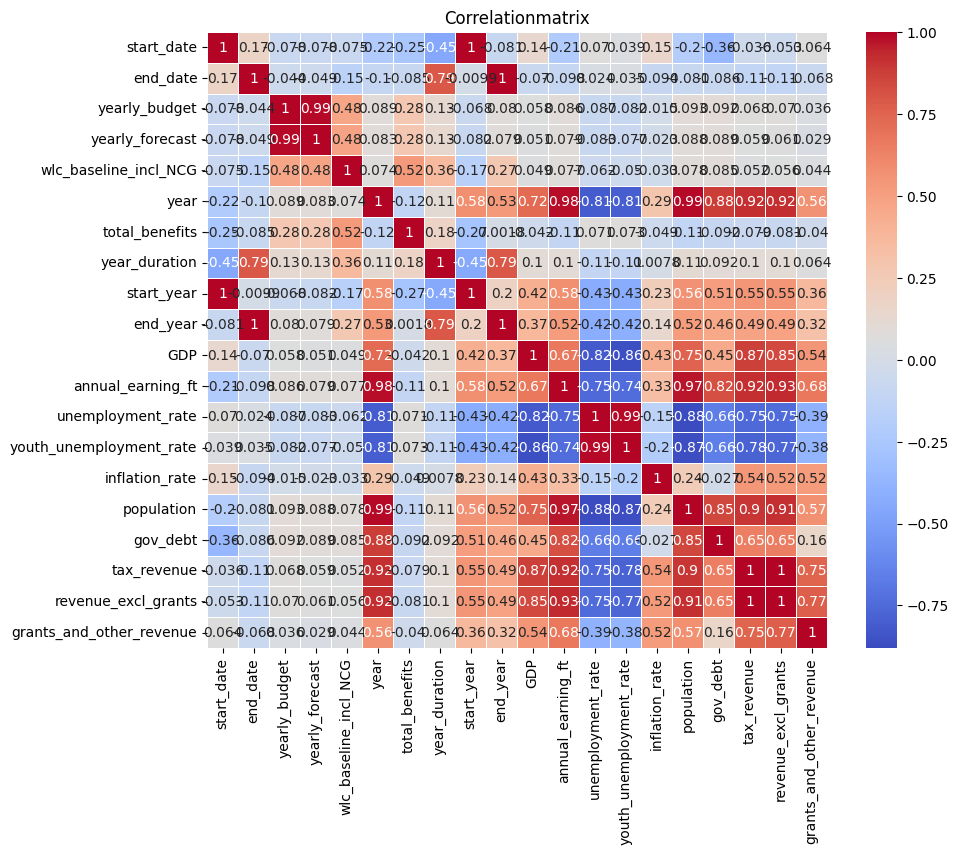

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('Correlationmatrix')
plt.show()


In [29]:
df = df.drop(columns=text_columns)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   project_name               1727 non-null   object        
 1   description_aims           1724 non-null   object        
 2   rating_comment             1723 non-null   object        
 3   start_date                 1581 non-null   datetime64[ns]
 4   end_date                   1617 non-null   datetime64[ns]
 5   schedule_comment           1719 non-null   object        
 6   yearly_budget              1590 non-null   float64       
 7   yearly_forecast            1592 non-null   float64       
 8   wlc_baseline_incl_NCG      1522 non-null   float64       
 9   variance_comment           1682 non-null   object        
 10  budget_comment             1717 non-null   object        
 11  year                       1727 non-null   float64       
 12  report

In [83]:
datetime = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()

df = df.drop(columns=datetime)

In [84]:
nan_counts = df.isna().sum()

print(nan_counts)


project_name                    1
description_aims                4
rating_comment                  5
schedule_comment                9
yearly_budget                 138
yearly_forecast               136
wlc_baseline_incl_NCG         206
variance_comment               46
budget_comment                 11
year                            1
report_category               539
project_number                624
total_benefits               1385
benefits_comment             1484
department_CO                   0
department_CPS                  0
department_DBT                  0
department_DCMS                 0
department_DEFRA                0
department_DEFRA & DFT          0
department_DESNZ                0
department_DFE                  0
department_DFID                 0
department_DFT                  0
department_DHSC                 0
department_DLUHC                0
department_DSIT                 0
department_DWP                  0
department_FCDO                 0
department_HML

In [85]:
df = df.drop(columns=['benefits_comment', 'total_benefits', 'project_number', 'report_category'])

In [86]:
nan_counts = df.isna().sum()

print(nan_counts)

project_name                   1
description_aims               4
rating_comment                 5
schedule_comment               9
yearly_budget                138
yearly_forecast              136
wlc_baseline_incl_NCG        206
variance_comment              46
budget_comment                11
year                           1
department_CO                  0
department_CPS                 0
department_DBT                 0
department_DCMS                0
department_DEFRA               0
department_DEFRA & DFT         0
department_DESNZ               0
department_DFE                 0
department_DFID                0
department_DFT                 0
department_DHSC                0
department_DLUHC               0
department_DSIT                0
department_DWP                 0
department_FCDO                0
department_HMLR                0
department_HMRC                0
department_HMT                 0
department_HO                  0
department_MOD                 0
department

In [87]:
df = df.dropna(subset=['yearly_budget', 'yearly_forecast', 'wlc_baseline_incl_NCG'])

In [88]:
nan_counts = df.isna().sum()

print(nan_counts)

project_name                   0
description_aims               1
rating_comment                 3
schedule_comment               6
yearly_budget                  0
yearly_forecast                0
wlc_baseline_incl_NCG          0
variance_comment              33
budget_comment                 2
year                           0
department_CO                  0
department_CPS                 0
department_DBT                 0
department_DCMS                0
department_DEFRA               0
department_DEFRA & DFT         0
department_DESNZ               0
department_DFE                 0
department_DFID                0
department_DFT                 0
department_DHSC                0
department_DLUHC               0
department_DSIT                0
department_DWP                 0
department_FCDO                0
department_HMLR                0
department_HMRC                0
department_HMT                 0
department_HO                  0
department_MOD                 0
department

In [92]:
text_columns = df.select_dtypes(include=['object']).columns.tolist()

In [93]:
df = df.drop(columns=text_columns)

In [96]:
df = df.drop(columns=['yearly_budget', 'wlc_baseline_incl_NCG'])

In [104]:
df = df_cleaned

In [108]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df.drop(columns=['yearly_forecast'])
y = df['yearly_forecast']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print(coefficients)


Mean Squared Error: 153466.25421660361
                      Feature   Coefficient
0                        year -8.859080e+05
1               department_CO -1.132721e+02
2              department_CPS -5.016471e+01
3              department_DBT -1.381940e+02
4             department_DCMS -1.005973e+02
5            department_DEFRA -5.614287e+01
6      department_DEFRA & DFT -7.727872e-03
7            department_DESNZ  1.623622e+02
8              department_DFE  1.411986e+02
9             department_DFID -2.660281e+02
10             department_DFT  1.087254e+02
11            department_DHSC -9.518670e+01
12           department_DLUHC  2.269678e+01
13            department_DSIT -1.816309e+02
14             department_DWP  9.215360e+01
15            department_FCDO -1.310900e+02
16            department_HMLR -2.257686e+02
17            department_HMRC -3.023483e+01
18             department_HMT -1.440596e+02
19              department_HO -4.085425e+01
20             department_MOD -3.1738

In [106]:
!pip install xgboost

  Using cached xgboost-2.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.1-py3-none-win_amd64.whl (124.9 MB)


In [113]:
from xgboost import XGBRegressor

X = df.drop(columns=['yearly_forecast'])
y = df['yearly_forecast']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f'Best Params: {best_params}')
print(f'Best negative MSE (Training): {best_score}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Test): {mse}')


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best negative MSE (Training): -230593.67518664393
Mean Squared Error (Test): 182631.953361914


In [120]:
!pip install bayesian-optimization

   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.9 MB 4.8 MB/s eta 0:00:03
   --------- ------------------------------ 3.1/12.9 MB 8.0 MB/s eta 0:00:02
   ----------------- ---------------------- 5.5/12.9 MB 9.1 MB/s eta 0:00:01
   ------------------------ --------------- 7.9/12.9 MB 9.7 MB/s eta 0:00:01
   ------------------------------ --------- 10.0/12.9 MB 10.0 MB/s eta 0:00:01
   -------------------------------------- - 12.3/12.9 MB 10.2 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 9.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3


  You can safely remove it manually.


In [123]:
!pip install hyperopt

  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.6 MB ? eta -:--:--
   ------------------- -------------------- 0.8/1.6 MB 2.1 MB/s eta 0:00:01
   --------------------------------- ------ 1.3/1.6 MB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------ --------------------- 0.8/1.7 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 4.0 MB/s eta 0:00:00
Using cached tqdm-4.66.5-py3-none-any.whl (78 kB)


In [124]:
from bayes_opt import BayesianOptimization
from hyperopt import hp, fmin, tpe

In [131]:
from sklearn.datasets import make_regression

X = df.drop(columns=['yearly_forecast'])
y = df['yearly_forecast']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function to minimize
def xgb_eval(max_depth, learning_rate, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'n_estimators': 100,
        'objective': 'reg:squarederror',
        'random_state': 42,
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    return score

# Define the search space
pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
}

# Perform Bayesian optimization
optimizer = BayesianOptimization(f=xgb_eval, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

# Print the best hyperparameters and score
print(f"Best hyperparameters: {optimizer.max['params']}")
print(f"Best score: {optimizer.max['target']:.4f}")

ImportError: numpy._core.multiarray failed to import